<center><h1> K-means Clustering Model on Facebook Live Sellers in Thailand Data Set </h1></center> 

<center><h4> Nyasha M, 28 Apr 2021 </h4></center>
<p>&nbsp;</p>

**Background:**
This dataset consists of 7050 Facebook posts of various types (live video, photos, status updates, links) from the Facebook pages of 10 Thai fashion and cosmetics retail sellers between March 2012 and June 2018. 

Each Facebook post had its engagement metrics (coonsisting of shares, comments, likes, or emoji reactions--namely, “love”, “wow”, “haha”, “sad” and “angry”) recorded into the dataset, along with a timestamp of when each engagement occurred.

The dataset came from the following webpage at the University of California Irvine (UCI): https://archive.ics.uci.edu/ml/datasets/Facebook+Live+Sellers+in+Thailand.

**Objective:**
The goal of this notebook was to determine if the Facebook posts of the sellers could be clustered in some way into distinct categories, such as by the type of media they posted, the types of engagement they generated from Facebook users, or by the year/month that the posts were made.

**Conclusions from the data:** The sellers generally fell into 3 groups:

* Clusters 0 and 1 belonged to sellers who posted mostly photos or links on Facebook.
    * Cluster 0 were sellers who generally obtained poor engagement from the public.
    * Cluster 1 generally obtained a very high number of reactions--mostly likes--from their posts.


* Cluster 2 belonged to sellers who posted mostly live videos.
    * These sellers generated a very high number of comments, as well as quite a few reactions, shares, and likes from the public.
---
**Citation:**
Nassim Dehouche and Apiradee Wongkitrungrueng. Facebook Live as a Direct Selling Channel, 2018, Proceedings of ANZMAC 2018: The 20th Conference of the Australian and New Zealand Marketing Academy. Adelaide (Australia), 3-5 December 2018.

---
### Data Exploration and Pre-processing

In [295]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sc

# Modeling
import sklearn.preprocessing as preprocess
from sklearn.cluster import KMeans as kmeans
from sklearn.metrics import silhouette_score

Let's first load and preview our dataset.

In [268]:
# load the dataset.
df = pd.read_csv("Live_20210128.csv")
df.head(3)

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,1,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,2,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,3,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN


In [226]:
len(df)

7050

The last 4 columns look like they all just consist of missing values. Is this true?

In [227]:
df.iloc[:,-4:].describe()

,Column1,Column2,Column3,Column4
count,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN


In [269]:
# Remove the missing data columns
df = df.drop(df.iloc[:,-4:], axis=1)
df.head(4)

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,1,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0
1,2,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0
2,3,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0
3,4,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0


photo     4288
video     2334
status     365
link        63
Name: status_type, dtype: int64


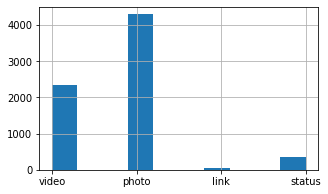

In [229]:
# status_type looks like a categorical variable. Is this true?
plt.figure(figsize=(5, 3))
df.status_type.hist()
print(df.status_type.value_counts())

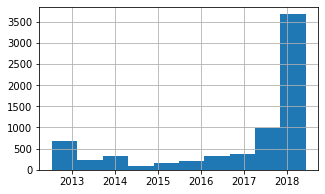

In [231]:
plt.figure(figsize=(5, 3))
df.status_published.astype('datetime64[s]').hist()

In [147]:
# How many columns are there excluding the first two columns (status and date)?
len(df.iloc[:,3:].columns)

9

Checking the distributions of the data in the 9 remaining columns.

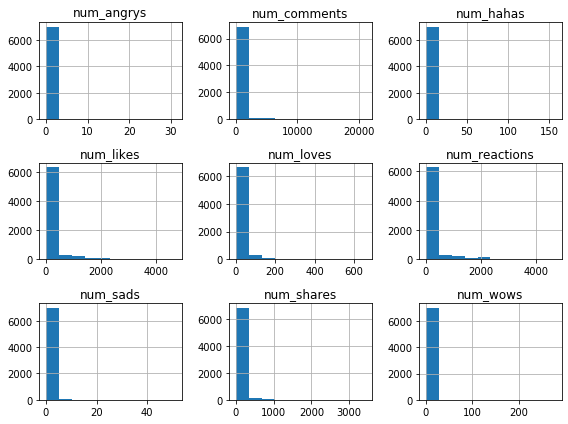

In [148]:
df[df.columns[3:]].hist(figsize=(8,6))
plt.tight_layout()
plt.show()

Is there any other missing data in the dataset?

In [149]:
df[df.isna().any(axis=1)]

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys


Let's remove the `status_id` variable since it seems to be just an arbitrary feature. 

`status_published` seems like it might have some interesting data that we could try feeding into our clustering algorithm. Let's try extracting the months and years out of this variable, in case these might provide some interesting results.

In [270]:
df = df.drop(['status_id'], axis=1)

Extracting the months and years from `status_published` returned an error, because it appears that this variable isn't actually in a datetime format. Let's check the format:

In [271]:
df['status_published'].dtypes

dtype('O')

Odd. What happens if we try changing it into a datetime object? Would this work?

In [272]:
df['date'] = pd.to_datetime(df['status_published'], errors='coerce')

In [273]:
# It did, so now let's extract the years and month from our new datetime column of 'status_published'. We can also now drop
# the old timestamp columns that we don't need anymore.
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

df = df.drop(['status_published', 'date'], axis=1)

Finally, K-means can only work on integers, so let's change `status_type` into an int-type feature.

In [275]:
le = preprocess.LabelEncoder()
df['status_type'] = le.fit_transform(df['status_type'])
df.head(4)

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,year,month
0,3,529,512,262,432,92,3,1,1,0,2018,4
1,1,150,0,0,150,0,0,0,0,0,2018,4
2,3,227,236,57,204,21,1,1,0,0,2018,4
3,1,111,0,0,111,0,0,0,0,0,2018,4
4,1,213,0,0,204,9,0,0,0,0,2018,4


In [276]:
# Standardizing the data.
clust_array = preprocess.StandardScaler().fit_transform(df)
clust_df = pd.DataFrame(data = clust_array, columns = df.columns)
clust_df.head(4)

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,year,month
0,1.374288,0.646104,0.323350,1.686879,0.482727,1.983266,0.196196,0.076713,0.473570,-0.155748,0.832651,-0.718661
1,-0.748106,-0.173192,-0.252206,-0.304144,-0.144720,-0.318454,-0.147879,-0.176010,-0.152587,-0.155748,0.832651,-0.718661
2,1.374288,-0.006738,0.013089,0.129017,-0.024571,0.206938,-0.033187,0.076713,-0.152587,-0.155748,0.832651,-0.718661
3,-0.748106,-0.257499,-0.252206,-0.304144,-0.231495,-0.318454,-0.147879,-0.176010,-0.152587,-0.155748,0.832651,-0.718661
4,-0.748106,-0.037003,-0.252206,-0.304144,-0.024571,-0.093286,-0.147879,-0.176010,-0.152587,-0.155748,0.832651,-0.718661


### Model Deployment

Let's run our clustering model on the data across a range of test/dummy cluster numbers and record which number of clusters lead to the best division of data/distinct groups in the dataset. 

We will plot the sum of squared errors after each cluster (i.e., the elbow method) as well as use the silhouette method to help us determine the ideal number of clusters for our dataset.

For n_clusters = 2 The average silhouette_score is : 0.6639750186216327
For n_clusters = 3 The average silhouette_score is : 0.5149693930635386
For n_clusters = 4 The average silhouette_score is : 0.31252549147051584
For n_clusters = 5 The average silhouette_score is : 0.26349116489928504
For n_clusters = 6 The average silhouette_score is : 0.3499857807955862
For n_clusters = 7 The average silhouette_score is : 0.35490824197305587
For n_clusters = 8 The average silhouette_score is : 0.35535464221158986
For n_clusters = 9 The average silhouette_score is : 0.35572238329166356
For n_clusters = 10 The average silhouette_score is : 0.3577116943825716
For n_clusters = 11 The average silhouette_score is : 0.37200366071156815


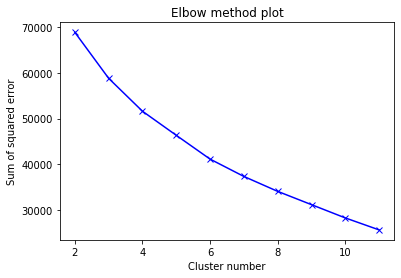

In [310]:
ss_dist = [np.nan]*10
for k in range(2, 12):
    # random_state = set.seed to determine where cluster centroids are placed--allows for reproducible results
    k_means = kmeans(n_clusters = k, init = 'k-means++', n_init = 12, random_state = 2)  
    k_means.fit(clust_df)
    # Record sum of squared errors from each cluster iteration. Find the number of clusters that explains the greatest
    # amount of variation in the data, withoout overfitting.
    ss_dist[k-2] = k_means.inertia_
    
    # Get silhouette score from each attempted cluster number
    labels = k_means.labels_
    silhouette_avg = silhouette_score(clust_df, labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    
plt.plot(range(2, 12), ss_dist, 'bx-')
plt.title('Elbow method plot'), plt.xlabel('Cluster number'), plt.ylabel('Sum of squared error')
plt.show()

The elbow method plot and our average silhouette scores post-modeling both suggest that perhaps 3 or 6 clusters might be best. Let's rerun our k-means model on just 3 clusters for now, apply the labels to our dataset, and see if we observe any interesting trends.

In [301]:
# pick a random cluster number for now. Run algorithm on the standardized dataset, then save the resulting cluster labels.
clust_num = 3

k_means = kmeans(init = "k-means++", n_clusters = clust_num, n_init = 12, random_state=2)
print(k_means.fit(clust_df))

labels = k_means.labels_
print(f"\n{labels}")

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=12, n_jobs=None, precompute_distances='auto',
       random_state=2, tol=0.0001, verbose=0)

[0 0 0 ... 0 0 0]


In [302]:
# apply the cluster labels to our original dataset.
df["clust_lab"] = labels
df.head(3)

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,year,month,clust_lab
0,3,529,512,262,432,92,3,1,1,0,2018,4,0
1,1,150,0,0,150,0,0,0,0,0,2018,4,0
2,3,227,236,57,204,21,1,1,0,0,2018,4,0


How many observations belonged to each cluster?

In [303]:
df.groupby('clust_lab').size()

clust_lab
0    6354
1     371
2     325
dtype: int64

In [304]:
df.groupby('clust_lab').mean()

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,year,month
clust_lab,,,,,,,,,,,,
0,1.652188,112.326881,92.434529,19.541706,104.439723,6.845924,0.538873,0.313031,0.137551,0.049103,2016.377715,6.630941
1,1.555256,1825.568733,61.463612,11.676550,1819.776280,3.113208,2.442049,0.199461,0.032345,0.005391,2015.412399,5.628032
2,2.907692,711.738462,2989.470769,472.796923,545.560000,138.716923,14.646154,8.760000,2.560000,1.489231,2017.575385,6.621538


Show what the original `status_type` labels were, as strings.

In [378]:
print(le.inverse_transform([0, 1, 2, 3]),
     "\n  0,\t 1,\t 2,\t  3")

['link' 'photo' 'status' 'video'] 
  0,	 1,	 2,	  3


### Conclusions

From looking at our aggregated dataframe, we can conclude that the Thai fashion and cosmetics sellers seemed to fall into 3 clusters:

* Clusters 0 and 1 belonged to sellers who posted mostly photos or links on Facebook.
    * Cluster 0 were sellers who generally obtained poor engagement from the public.
    * Cluster 1 generally obtained a very high number of reactions--mostly likes--from their posts.


* Cluster 2 belonged to sellers who posted mostly live videos.
    * These sellers generated a very high number of comments, as well as quite a few reactions, shares, and likes from the public.

### Bonus Data Exploration Area Below:

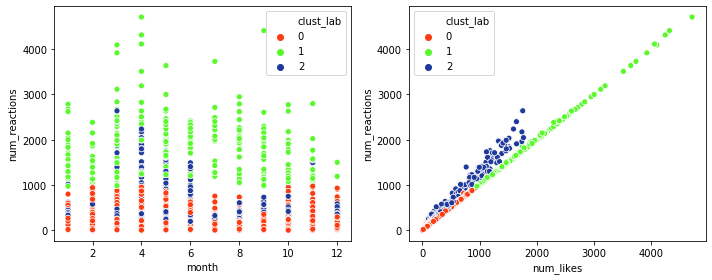

In [363]:
colours = ["#FB3C12", "#5AF92D", "#203A9B"] # Red, green, blue

# Exploring some of the data.
fig,axs = plt.subplots(1,2, figsize=(10,4))

sns.scatterplot('month', 'num_reactions', data=df, hue='clust_lab', palette=colours, ax=axs[0])
sns.scatterplot('num_likes', 'num_reactions', data=df, hue='clust_lab', palette=colours, ax=axs[1])
fig.tight_layout()